In [1]:
import h5py
import pandas as pd
import numpy as np
from statistics import mode
from vae import Vae
import tensorflow as tf
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from PIL import Image, ImageEnhance

In [2]:
numeral = 'i'

In [3]:
(images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
images = np.expand_dims(images, 3)
images = np.round(images.astype(np.float32) / 255)
N = len(images)
images = np.concatenate([images, np.zeros((N, 4, 28, 1))], axis=1)
images = np.concatenate([images, np.zeros((N, 32, 4, 1))], axis=2)
images = images[:int(5e3)]
images = images.astype(np.float32)
images.shape

(5000, 32, 32, 1)

In [4]:
with h5py.File('./image_data_{}.h5'.format(numeral), 'r') as f:
    images = f['images'][...].astype(np.float32) / 255
    images = np.expand_dims(images, 3)
    labels = f['labels'][...].astype(np.float32)
    
images.shape, labels.shape

((212, 32, 32, 1), (212, 10))

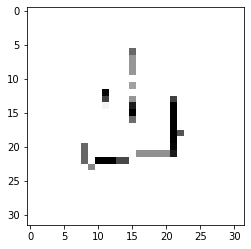

In [5]:
plt.imshow(images[2, :, :, 0], cmap='binary_r')

In [6]:
images.min(), images.max()

(0.0, 1.0)

In [7]:
vae = Vae(images, latent_dim=4, learning_rate=1e-3, standardize_data=False, kl_weight=1.5, validation_split=0.05)

In [8]:
vae.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0         
_________________________________________________________________
dense (Dense)                (None, 8)                 346120    
Total params: 369,416
Trainable params: 369,416
Non-trainable params: 0
_________________________________________________________________


In [9]:
vae.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10816)             54080     
_________________________________________________________________
reshape (Reshape)            (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 64)        9280      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 30, 30, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 16)        4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 1)         145       
Total params: 86,593
Trainable params: 86,593
Non-trainable params: 0
__________________________________________________

In [10]:
vae._mean, vae._std, vae.train_x.shape, vae.val_x.shape

(0, 1, (202, 32, 32, 1), (10, 32, 32, 1))

In [11]:
len(images) / 8

26.5

In [12]:
vae.train(n_epoch=100, n_batch=8)

Epoch #0, train loss: 585.230, validation loss: 587.049
Epoch #1, train loss: 324.788, validation loss: 303.595
Epoch #2, train loss: 281.792, validation loss: 254.387
Epoch #3, train loss: 236.761, validation loss: 202.373
Epoch #4, train loss: 218.305, validation loss: 189.671
Epoch #5, train loss: 203.299, validation loss: 169.762
Epoch #6, train loss: 195.738, validation loss: 163.938
Epoch #7, train loss: 189.338, validation loss: 155.604
Epoch #8, train loss: 184.459, validation loss: 154.592
Epoch #9, train loss: 179.169, validation loss: 149.901
Epoch #10, train loss: 177.705, validation loss: 146.543
Epoch #11, train loss: 176.637, validation loss: 149.139
Epoch #12, train loss: 174.011, validation loss: 146.223
Epoch #13, train loss: 171.228, validation loss: 141.942
Epoch #14, train loss: 167.336, validation loss: 141.745
Epoch #15, train loss: 165.309, validation loss: 138.687
Epoch #16, train loss: 159.775, validation loss: 134.314
Epoch #17, train loss: 156.470, validatio

In [13]:
vae.train_history.tail()

,train_loss,train_rec_loss,train_kl_loss,val_loss,val_rec_loss,val_kl_loss
95,80.194954,-65.092888,-10.068045,129.820587,-115.384109,-9.624321
96,79.159927,-63.936035,-10.149261,129.333542,-115.175415,-9.438755
97,77.595062,-62.747654,-9.898271,137.478058,-124.294960,-8.788729
98,77.594078,-62.799736,-9.862897,138.420349,-125.397339,-8.682008
99,77.357887,-62.275715,-10.054784,133.472336,-118.901047,-9.714199


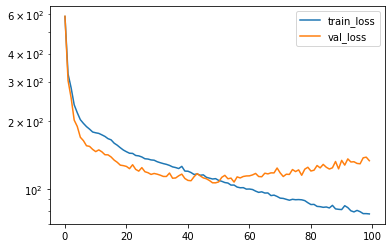

In [14]:
vae.train_history[['train_loss', 'val_loss']].plot()
plt.yscale('log')

In [15]:
vae.save('./vae_{}.zip'.format(numeral))
loaded = Vae.load(images, './vae_{}.zip'.format(numeral))

INFO:tensorflow:Assets written to: /tmp/tmp97j7a08n/encoder_model/assets
INFO:tensorflow:Assets written to: /tmp/tmp97j7a08n/decoder_model/assets


# Train Images

In [16]:
z = vae.encode(vae.train_x)[0].numpy()
out = vae.decode(z, standardize=False, numpy=False, apply_sigmoid=True, to_image=True)

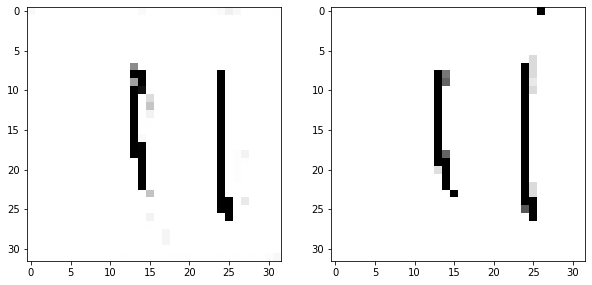

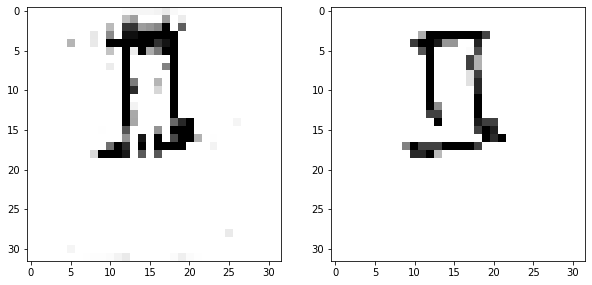

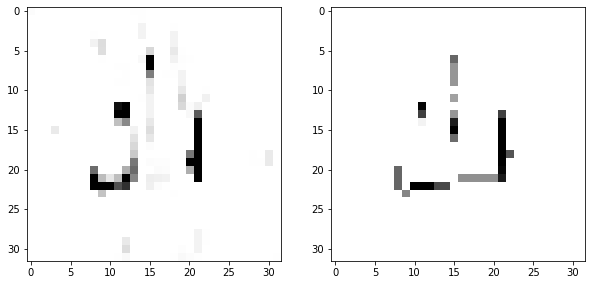

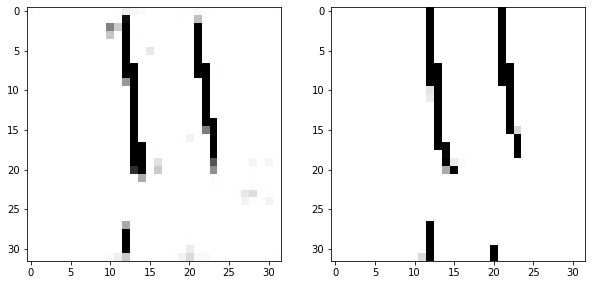

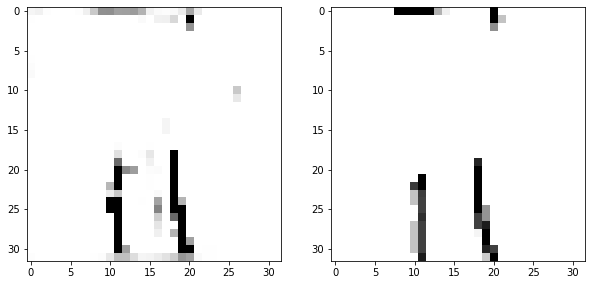

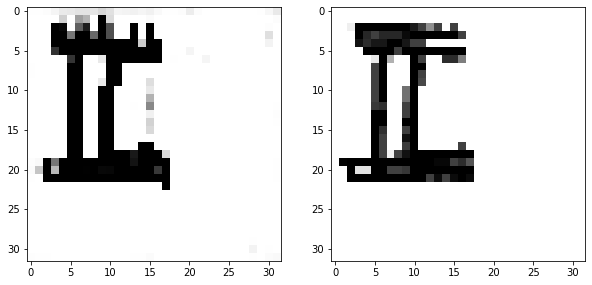

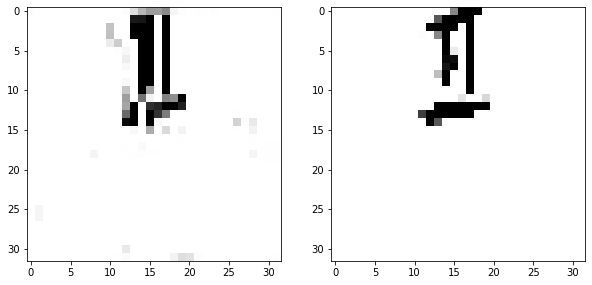

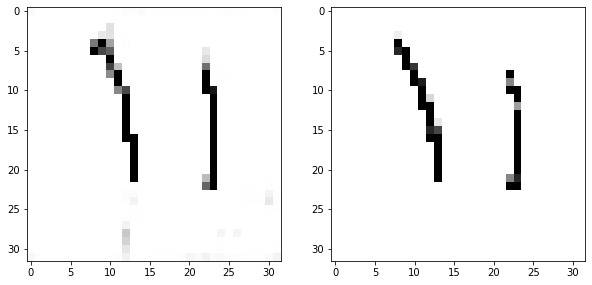

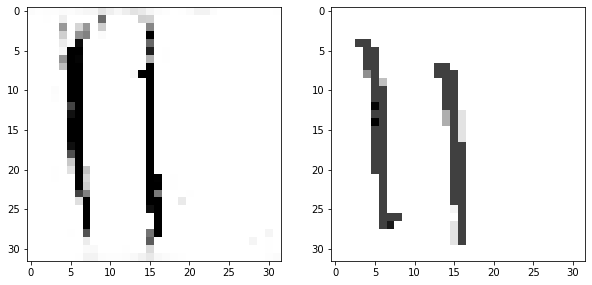

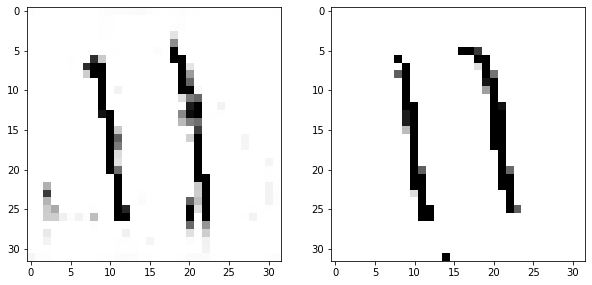

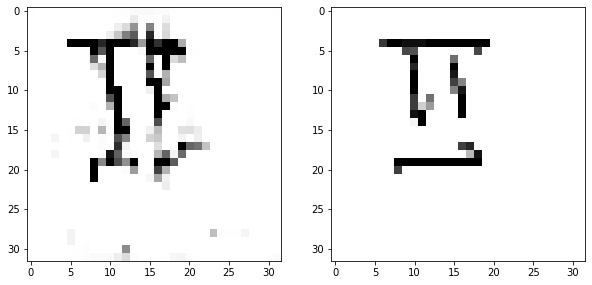

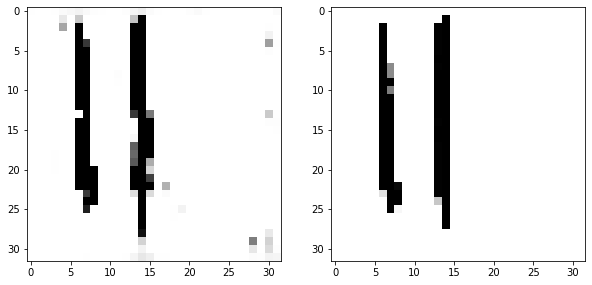

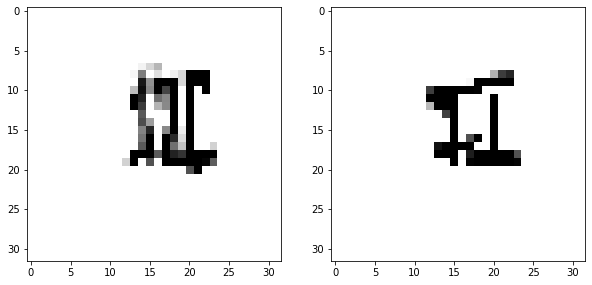

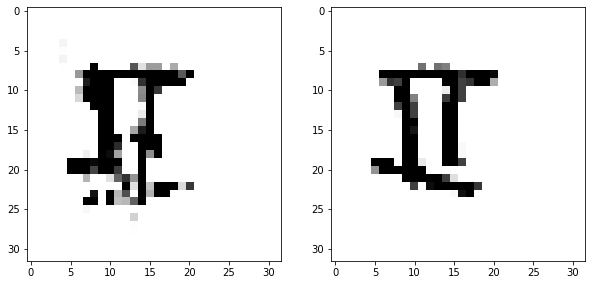

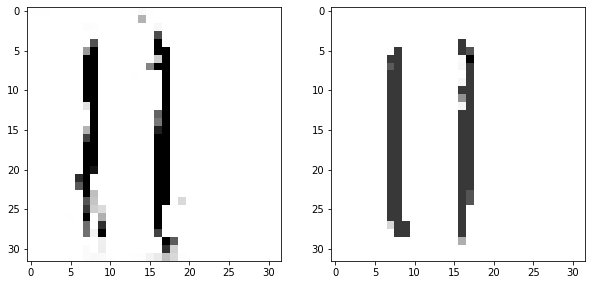

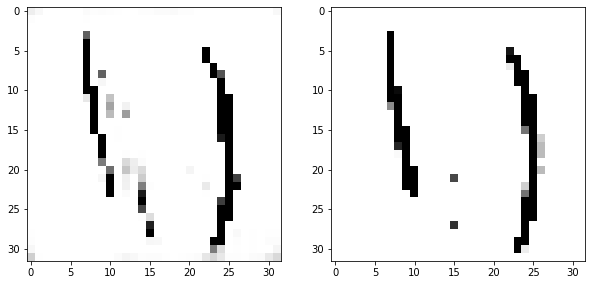

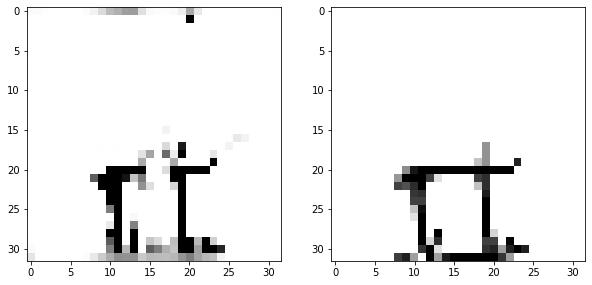

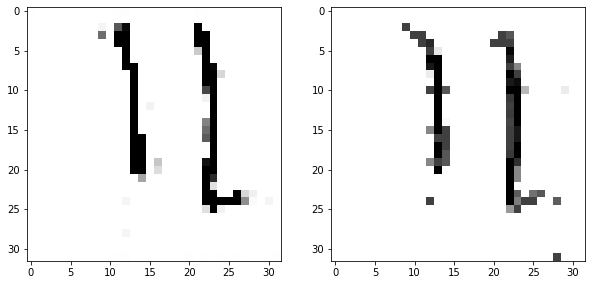

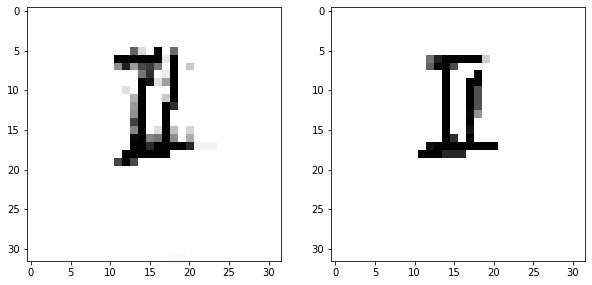

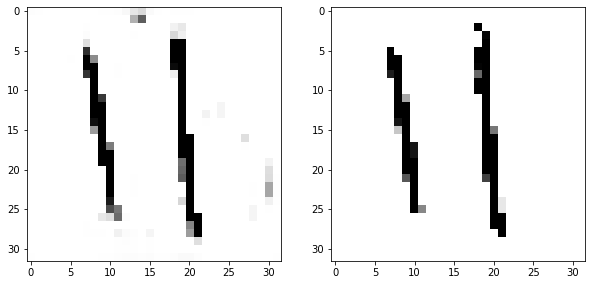

In [17]:
for i in range(20):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    image = out[i]
    image = Image.fromarray(image)
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(10)
    
    ax1.imshow(image, cmap='binary_r')
    ax2.imshow(vae.train_x[i, :, :, 0], cmap='binary_r')

# Synthetic Images

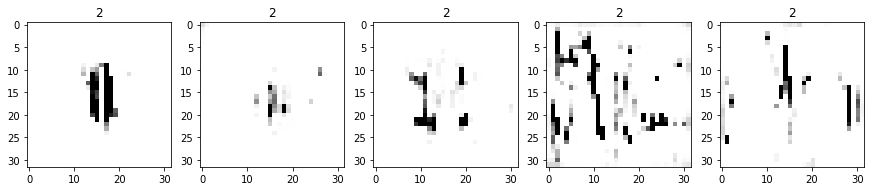

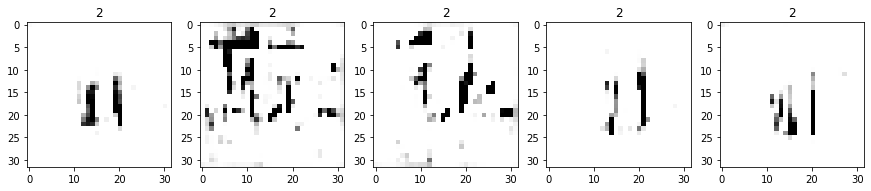

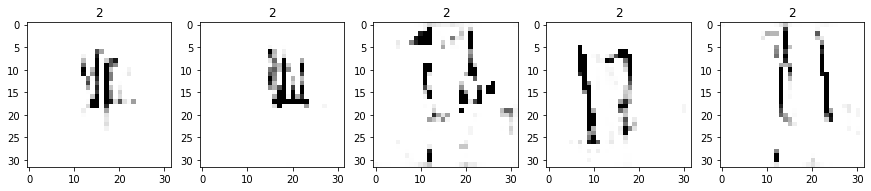

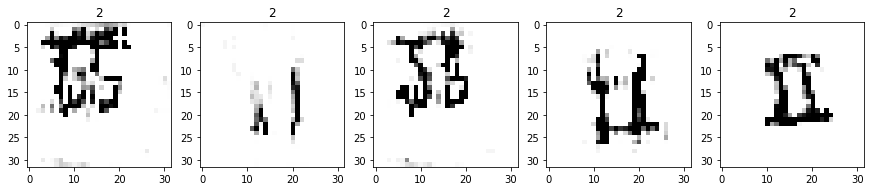

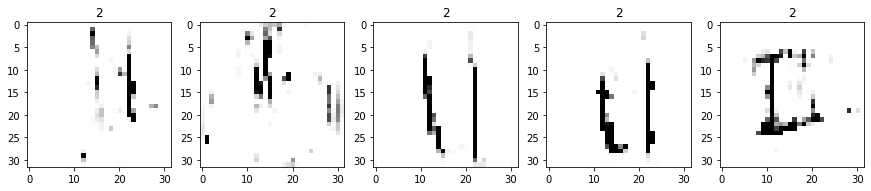

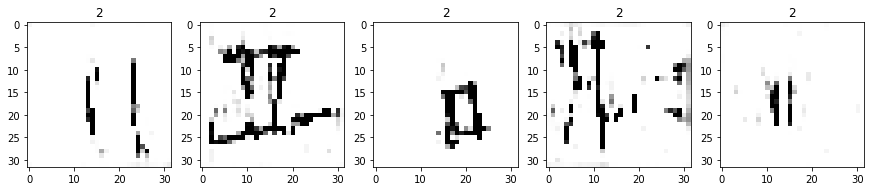

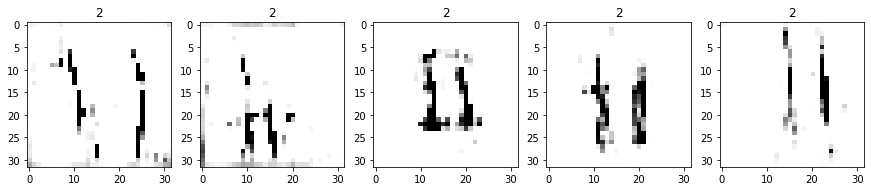

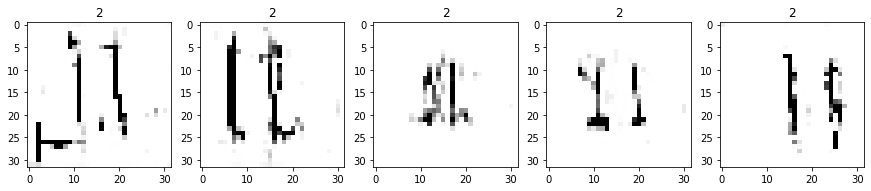

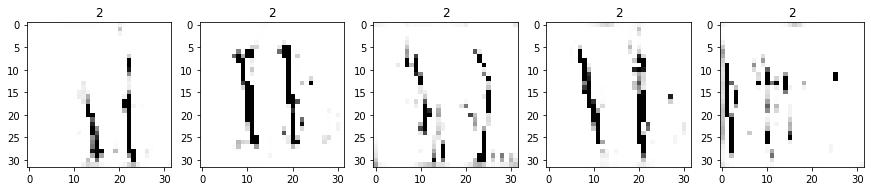

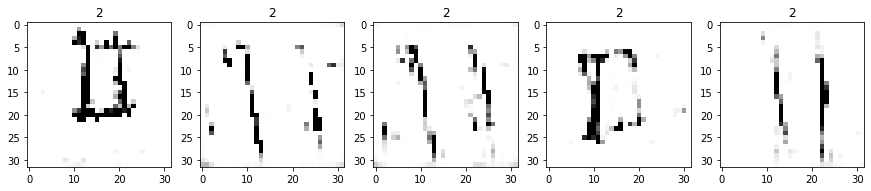

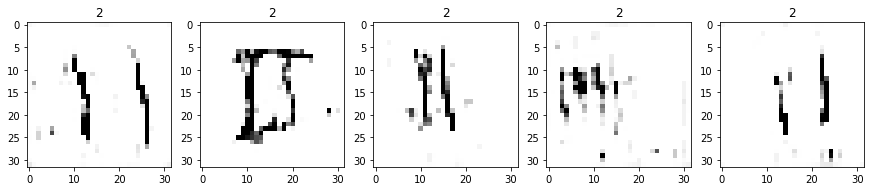

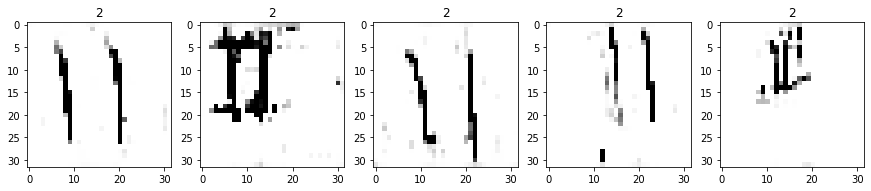

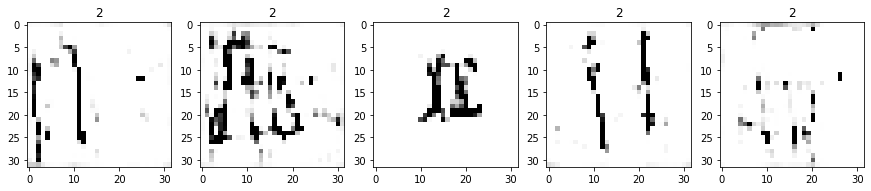

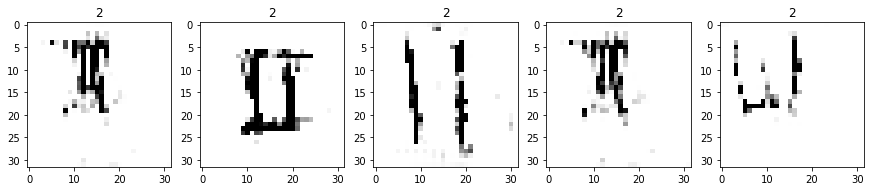

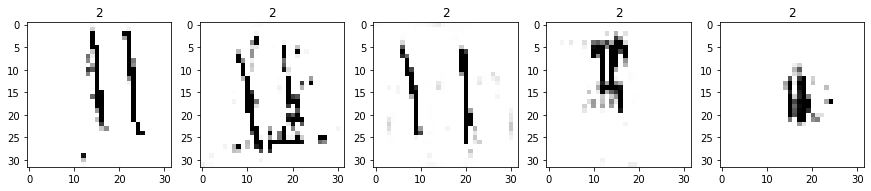

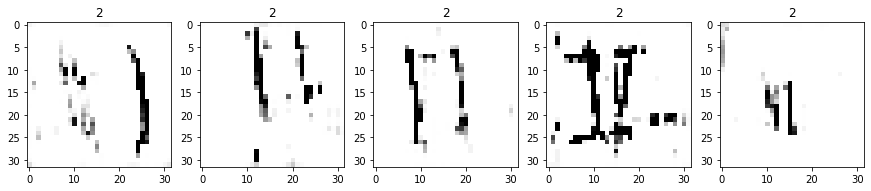

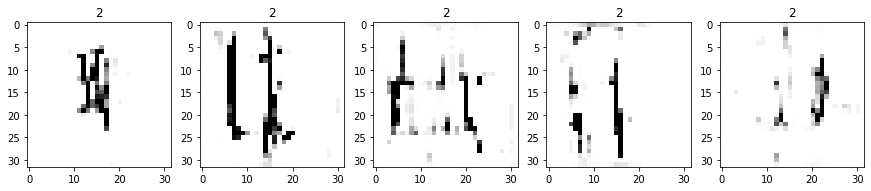

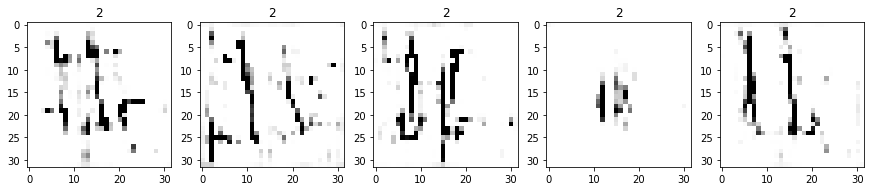

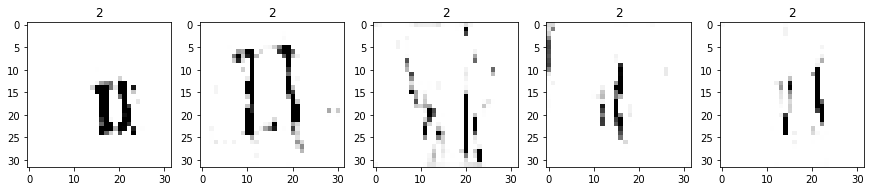

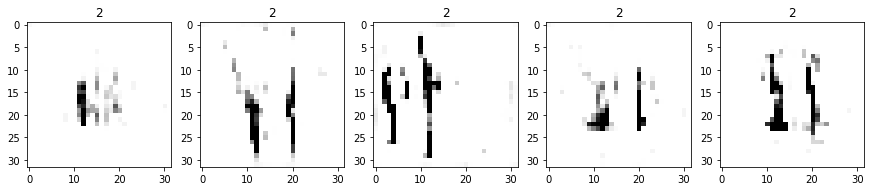

In [18]:
eps = tf.random.normal(shape=(100, vae.latent_dim))

z = vae.encode(images)[0].numpy()
tree = cKDTree(z)
dist, inn = tree.query(eps, k=1)

if len(inn.shape) == 1:
    nn_labels = np.where(labels[inn])[1] + 1
else:
    nn_labels = np.zeros(len(images))
    for i in range(inn.shape[0]):
        nn_labels[i] = mode([np.where(labels[j])[0][0] + 1 for j in inn[i, :].flatten()])

out = vae.sample(eps=eps, standardize=False, numpy=True, apply_sigmoid=True, to_image=True)

for i in range(20):
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152)
    ax3 = fig.add_subplot(153)
    ax4 = fig.add_subplot(154)
    ax5 = fig.add_subplot(155)
    for j, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
        k = i*5+j
        im_eps = eps[k].numpy()
        
        image = Image.fromarray(out[k])
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(10)
        
        ax.imshow(image, cmap='binary_r')
        ax.set_title(nn_labels[k])
    


# Check Loaded Model

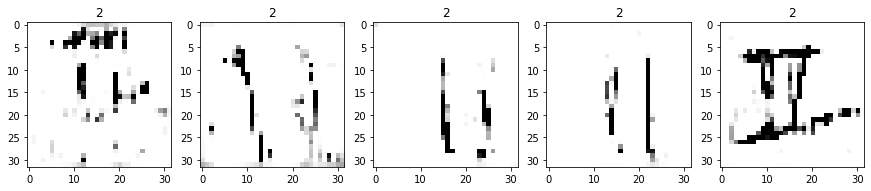

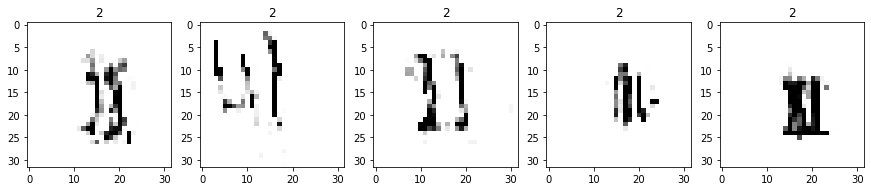

In [19]:
eps = tf.random.normal(shape=(100, loaded.latent_dim))

z = loaded.encode(images)[0].numpy()
tree = cKDTree(z)
dist, inn = tree.query(eps, k=1)

if len(inn.shape) == 1:
    nn_labels = np.where(labels[inn])[1] + 1
else:
    nn_labels = np.zeros(len(images))
    for i in range(inn.shape[0]):
        nn_labels[i] = mode([np.where(labels[j])[0][0] + 1 for j in inn[i, :].flatten()])

out = loaded.sample(eps=eps, standardize=False, numpy=True, apply_sigmoid=True, to_image=True)

for i in range(2):
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(151)
    ax2 = fig.add_subplot(152)
    ax3 = fig.add_subplot(153)
    ax4 = fig.add_subplot(154)
    ax5 = fig.add_subplot(155)
    for j, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
        k = i*5+j
        im_eps = eps[k].numpy()
        
        image = Image.fromarray(out[k])
        enhancer = ImageEnhance.Sharpness(image)
        image = enhancer.enhance(10)
        
        ax.imshow(image, cmap='binary_r')
        ax.set_title(nn_labels[k])
    


# Save Models to Data Dir

In [20]:
N = 600

eps = tf.random.normal(shape=(N, vae.latent_dim))
z = vae.encode(images)[0].numpy()
out = vae.sample(eps=eps, standardize=False, numpy=True, apply_sigmoid=True, to_image=True)

for i in range(N):
    image = Image.fromarray(out[i])
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(10)

    image.save("./data/data/train/{0}/{0}_{1}.png".format(numeral, str(i).zfill(4)))
